In [3]:
!pip install boto3
!pip install textstat
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.3 MB/s eta 0:00:00


### Orden de las carpetas de datos

Resumen: La carpeta Cochrane tiene dos carpetas, train y test, y cada subcarpeta tiene texto simplificado y médico, original y aumentado. Usaremos tanto el texto aumentado como el original, simplificado y médico, de las dos carpetas. La carpeta Pfizer tiene tres subcarpetas, original text, test y train, solo de texto simplificado, de las cuales usaremos test y train. La carpeta ClinicalTrials tiene dos subcarpetas, train y test, con el texto médico de los textos simplificados de la carpeta Pfizer. La carpeta Trial Summaries tiene 4 subcarpetas con archivos de texto simplificado (carpetas utiles med y alx) sin texto médico equivalente disponible.

Cochrane

The Cochrane dataset is divided into two main folders: train and test.
* Train
  * non_pls: 6641 texts
  * non_pls aumented: 24477 texts
  * non_pls total: 31118 texts
  * pls: 4496 texts
  * pls aumented: 11745 texts
  * pls total: 16241 texts
* Test
  * non_pls: 1661 texts
  * non_pls aumented: 6003 texts
  * non_pls total: 7664 texts
  * pls: 1124 texts
  * pls aumented: 2816 texts
  * pls total: 3940 texts

Pfizer

The Pfizer dataset has three folders:
* original_pfizer_texts: Contains 130 PDFs with Original Plain Language Study Results Summaries from Pfizer.
* test: Contains 117 texts extracted from the original PDFs and augmented by paragraphs.
* train: Contains 491 texts extracted from the original PDFs and augmented by paragraphs.

Trial Summaries

The Trial Summaries dataset includes texts in plain language and is organized into four folders:
* original_texts
  * alx: 6 PDFs with clinical results by Alexion
  * amg: 16 PDFs with clinical results by Amgen
  * ast: 202 PDFs with clinical results by Astellas Pharma
  * csl: 9 PDFs with clinical results by CSL Bering
  * gsk: 95 PDFs with clinical results by GSK
  * ins: 1 PDF with clinical results by Inside
  * lbi: 1 PDF with clinical results by Lung Biotechnology
  * med: 290 PDFs with clinical results by AstraZeneca and MedImmune
  * sep: 1 PDF with clinical results by Sunovion
  * viv: 12 PDFs with clinical results by ViiV Healthcare
* not_taken_texts
Contains texts that were not selected for further processing.
* med
Contains 979 texts extracted from the med documents.
* alx
Contains 57 texts extracted from the alx documents.

ClinicalTrials.gov

The ClinicalTrials.gov dataset is organized into two folders, with data extracted using the NCT (National Clinical Trial ID number) of the Pfizer documents:
* train
Contains 623 texts extracted from the API and augmented by paragraphs similar to the Pfizer folder.
* test
Contains 130 texts extracted from the API and augmented by paragraphs similar to the Pfizer folder.

### Librerías

In [4]:
# Uso general
import os, random, unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data import
import boto3
from google.colab import userdata

# Pre procesamiento de datos
from io import BytesIO
from PyPDF2 import PdfReader
import re
from collections import Counter
import textstat
from datasets import Dataset, DatasetDict
from smart_open import open as sopen
from transformers import AutoTokenizer

### Data Import

In [5]:
AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID_PROJECT')
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY_PROJECT')
AWS_DEFAULT_REGION = 'us-east-2'

s3 = boto3.client('s3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION)

# --- Configuración de S3 ---
s3_uri = "s3://maia-grupo-9"
bucket_name = s3_uri.split('/')[2]             # nombre del bucket
s3_prefix = 'original_data'

print(f"Cargando datos desde el bucket: {bucket_name}")

Cargando datos desde el bucket: maia-grupo-9


In [6]:
# Loop para leer todos los archivos del bucket
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix=s3_prefix)

files = []
for page in pages:
  if files==[]:
    print(f"Ejemplo de formato de Metadata: {page['Contents'][0]}")
    for obj in page.get('Contents', []):
      files.append(obj['Key'])
  else:
    for obj in page.get('Contents', []):
      files.append(obj['Key'])

print(f"Total files: {len(files)}")

Ejemplo de formato de Metadata: {'Key': 'original_data/.DS_Store', 'LastModified': datetime.datetime(2025, 10, 15, 7, 10, 29, tzinfo=tzlocal()), 'ETag': '"fcb91a488e5462567fd10e70c8f6d1f1"', 'ChecksumAlgorithm': ['CRC32'], 'ChecksumType': 'FULL_OBJECT', 'Size': 10244, 'StorageClass': 'STANDARD'}
Total files: 65945


### Pre procesamiento

In [7]:
# Funciones para extraer rutas de documentos .txt y .pdf
def read_s3_text(key):
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    return obj['Body'].read().decode('utf-8', errors='ignore')

def read_s3_pdf(key):
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    pdf = PdfReader(BytesIO(obj['Body'].read()))
    return " ".join([page.extract_text() for page in pdf.pages if page.extract_text()])

# Extrae la ruta de los documentos
sample_txt = [f for f in files if f.endswith('.txt')]                           # Rutas de archivos .txt
#sample_pdf = [f for f in files if f.endswith('.pdf')][:100]                    # Rutas de archivos .pdf (no necesarios)
if sample_txt==[]:
  print("No hay archivos .txt")

In [8]:
# División de textos en simplificados y médicos
all_medical_texts = []
all_summaries = []
for i in range(len(sample_txt)):
  carpeta = '/'.join(sample_txt[i].split('/')[1:2])                # Nombre del origen (Pfizer, Cochrane, etc)
  subcarpeta = '/'.join(sample_txt[i].split('/')[2:3])             # Nombre de la subcarpeta (train, test, med, alx)
  subcarpeta2 = '/'.join(sample_txt[i].split('/')[3:4])            # Nombre de la sub subcarpeta (pls, non pls, etc)
  if carpeta=='Pfizer' and subcarpeta=='test':
    all_summaries.append(sample_txt[i])
  elif carpeta=='Pfizer' and subcarpeta=='train':
    all_summaries.append(sample_txt[i])

  if carpeta=='ClinicalTrials.gov' and subcarpeta=='test':
    all_medical_texts.append(sample_txt[i])
  elif carpeta=='ClinicalTrials.gov' and subcarpeta=='train':
    all_medical_texts.append(sample_txt[i])

  if carpeta=='Cochrane' and subcarpeta2=='non_pls':
    all_medical_texts.append(sample_txt[i])
  elif carpeta=='Cochrane' and subcarpeta2=='pls':
    all_summaries.append(sample_txt[i])

  if carpeta=='Trial Summaries' and subcarpeta=='med':
    all_summaries.append(sample_txt[i])
  elif carpeta=='Trial Summaries' and subcarpeta=='alx':
    all_summaries.append(sample_txt[i])
print(f'Total de textos médicos: {len(all_medical_texts)}')
print(f'Total de textos simplificados: {len(all_summaries)}')

Total de textos médicos: 39533
Total de textos simplificados: 21821


In [9]:
# Une los textos en un solo str de 200 textos de prueba
med = [read_s3_text(i) for i in all_medical_texts[:200]]
sums = [read_s3_text(i) for i in all_summaries[:200]]
med_combined = " ".join(med)
sum_combined = " ".join(sums)

# Estadísticas
med_avg_length = sum(len(t.split()) for t in med) / len(med)
sum_avg_length = sum(len(t.split()) for t in sums) / len(sums)
med_top_terms = Counter(re.findall(r'\b[a-zA-Z]+\b', med_combined.lower())).most_common(30)
sum_top_terms = Counter(re.findall(r'\b[a-zA-Z]+\b', sum_combined.lower())).most_common(30)

print(f'Número total de téxtos médicos: {len(med)}')
print(f'Número total de textos simplificados: {len(sums)}')
print(f"Longitud promedio de textos médicos: {med_avg_length:.0f} palabras")
print(f'Longitud promedio de textos simplificados: {sum_avg_length:.0f} palabras')
print("Top terms en textos médicos:", med_top_terms)
print("Top terms en textos simplificados:", sum_top_terms)

Número total de téxtos médicos: 200
Número total de textos simplificados: 200
Longitud promedio de textos médicos: 845 palabras
Longitud promedio de textos simplificados: 424 palabras
Top terms en textos médicos: [('of', 6671), ('the', 6101), ('and', 4620), ('to', 4186), ('a', 2632), ('in', 2553), ('or', 2506), ('was', 2192), ('for', 2003), ('with', 1894), ('as', 1476), ('participants', 1410), ('from', 1341), ('on', 1157), ('at', 1149), ('treatment', 1037), ('were', 1025), ('scores', 922), ('score', 916), ('no', 914), ('study', 866), ('baseline', 861), ('participant', 808), ('is', 807), ('pain', 798), ('all', 788), ('that', 787), ('defined', 783), ('by', 718), ('symptoms', 703)]
Top terms en textos simplificados: [('the', 4017), ('of', 3291), ('to', 2236), ('and', 1974), ('in', 1945), ('a', 1529), ('with', 1357), ('for', 1125), ('or', 1089), ('is', 1039), ('we', 927), ('people', 771), ('are', 661), ('studies', 658), ('that', 636), ('treatment', 591), ('this', 585), ('were', 542), ('evi

In [10]:
# Normalización de texto
def clean_text(text):
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r'\s+', ' ', text)                                             # Remueve espacios en blanco dobles
    text = re.sub(r"[^a-zA-Z0-9.,;:!?\-+*/=%()°μµ×·±≤≥≈~‰^%$#@'\"]", ' ', text)  # Elimina todo menos letras, dígitos y algunos signos de puntuación
    text = re.sub(r'\b(\d{1,2}/\d{1,2}/\d{2,4}|\d{4}-\d{2}-\d{2})\b', ' ', text) # Elimina fechas
    return text.lower()
med_combined_clean = clean_text(med_combined)
sum_combined_clean = clean_text(sum_combined)

In [11]:
# Estadísticas del texto original (muestra de 200 textos)
print("Gunning Fog:", textstat.gunning_fog(med_combined_clean))                           # si 17: college grad - si 14: college sophomore
print("Flesch Reading Ease:", textstat.flesch_reading_ease(med_combined_clean))           # 30-49: Difficult. Más alto mejor hasta 121.22
print("Smog Index:", textstat.smog_index(med_combined_clean))                             # texto de mínimo 30 frases
print("Flesch-Kincaid Grade Level:", textstat.flesch_kincaid_grade(med_combined_clean))   # igual que Gunning fog
print("Coleman-Liau Index:", textstat.coleman_liau_index(med_combined_clean))
print("Dale-Chall Score:", textstat.dale_chall_readability_score(med_combined_clean))
print("Consenso de Legibilidad:", textstat.text_standard(med_combined_clean))             # Consenso de todos los anteriores índices

Gunning Fog: 18.0791062288103
Flesch Reading Ease: 31.246332606191373
Smog Index: 16.172989045142906
Flesch-Kincaid Grade Level: 14.714642900676456
Coleman-Liau Index: 13.96641923530603
Dale-Chall Score: 13.294522638516481
Consenso de Legibilidad: 13th and 14th grade


In [12]:
# Estadísticas del texto simplificado (muestra de 200 textos)
print("Gunning Fog:", textstat.gunning_fog(sum_combined_clean))                           # si 17: college grad - si 14: college sophomore
print("Flesch Reading Ease:", textstat.flesch_reading_ease(sum_combined_clean))           # 30-49: Difficult. Más alto mejor hasta 121.22
print("Smog Index:", textstat.smog_index(sum_combined_clean))                             # texto de mínimo 30 frases
print("Flesch-Kincaid Grade Level:", textstat.flesch_kincaid_grade(sum_combined_clean))   # igual que Gunning fog
print("Coleman-Liau Index:", textstat.coleman_liau_index(sum_combined_clean))
print("Dale-Chall Score:", textstat.dale_chall_readability_score(sum_combined_clean))
print("Consenso de Legibilidad:", textstat.text_standard(sum_combined_clean))             # Consenso de todos los anteriores índices

Gunning Fog: 14.601784488949784
Flesch Reading Ease: 43.83609408721841
Smog Index: 13.861169248026044
Flesch-Kincaid Grade Level: 12.09836693681288
Coleman-Liau Index: 12.600035015640323
Dale-Chall Score: 11.151295491112243
Consenso de Legibilidad: 12th and 13th grade


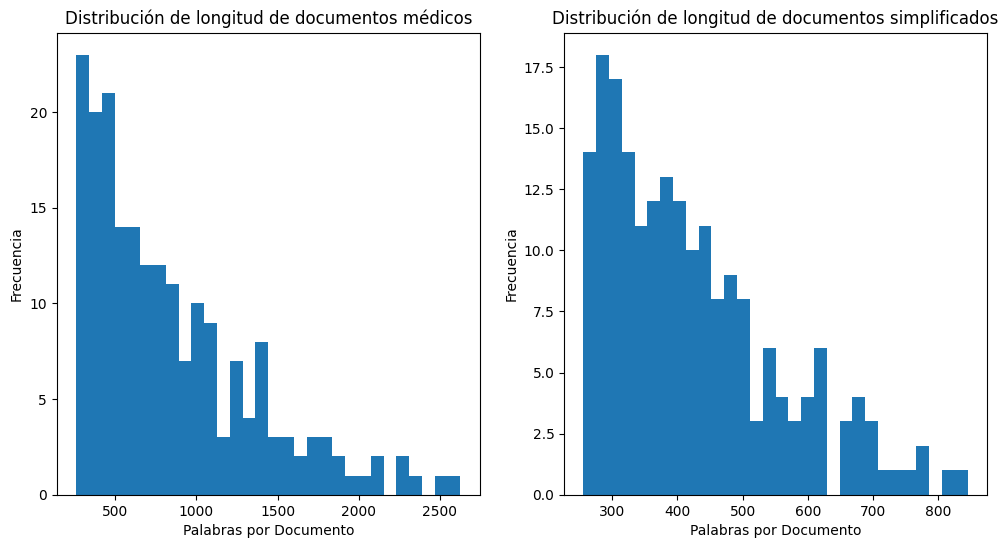

In [13]:
# Gráfico de distribución de longitud de texto
med_lengths = [len(t.split()) for t in med]
sum_lengths = [len(t.split()) for t in sums]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(med_lengths, bins=30)
plt.xlabel("Palabras por Documento")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitud de documentos médicos")
plt.subplot(1, 2, 2)
plt.hist(sum_lengths, bins=30)
plt.xlabel("Palabras por Documento")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitud de documentos simplificados")
plt.show()

### Data split

In [14]:
# Se divide por origen para parejas text0 médico-summary
pfizer = [res for res in all_summaries if res.split('/')[1]=='Pfizer']
ctrials = [res for res in all_medical_texts if res.split('/')[1]=='ClinicalTrials.gov']
cochrane_med = [res for res in all_medical_texts if res.split('/')[1]=='Cochrane']
cochrane_pls = [res for res in all_summaries if res.split('/')[1]=='Cochrane']
trialsums = [res for res in all_summaries if res.split('/')[1]=='Trial Summaries']
print(f'Pfizer: {len(pfizer)}')
print(f'ClinicalTrials.gov: {len(ctrials)}')
print(f'Cochrane No pls: {len(cochrane_med)}')
print(f'Cochrane pls: {len(cochrane_pls)}')
print(f'Trial Summaries: {len(trialsums)}')

Pfizer: 606
ClinicalTrials.gov: 751
Cochrane No pls: 38782
Cochrane pls: 20181
Trial Summaries: 1034


In [15]:
# Función que extrae los IDs únicos de Cochrane
def extract_cd_id(name):
    cd = re.search(r'(CD\d+)', name)
    mr = re.search(r'(MR\d+)', name)
    if not cd and not mr:
      return None
    return cd.group(1) if cd else mr.group(1)

# Crea DFs según ID
med_df = pd.DataFrame({"medical": cochrane_med, "id": [extract_cd_id(f) for f in cochrane_med]})
pls_df = pd.DataFrame({"summary": cochrane_pls, "id": [extract_cd_id(f) for f in cochrane_pls]})

# Une los DF por la columna ID
rutas_df = med_df.merge(pls_df, on="id", how="inner")[["medical", "summary"]]
rutas_df.shape

(130055, 2)

In [16]:
# Une los datos de Pfizer y Clinical Trials al DF
for i in pfizer:
  for j in ctrials:
    if i.split('/')[4]==j.split('/')[3]:
      rutas_df.loc[len(rutas_df)] = [j, i]
print(rutas_df.shape)

(130206, 2)


In [17]:
# Data split
data = {"medical": rutas_df["medical"].tolist(), "summary": rutas_df["summary"].tolist()}
dataset = Dataset.from_dict(data)

# Split 90% train y 10% temp
train_testvalid = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_testvalid['train']
temp_dataset = train_testvalid['test']

# Split en validación y test (0.5% del total del dataset)
test_valid = temp_dataset.train_test_split(test_size=0.5, seed=42)
validation_dataset = test_valid['train']
test_dataset = test_valid['test']

# Crea Dataset final con rutas
final_dataset = DatasetDict({'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset})
final_dataset

In [19]:
# Función para crear rutas validas de S3
def to_s3_url(base_uri, key_or_url):
    if key_or_url.startswith("s3://"):
        return key_or_url
    return f"{base_uri.rstrip('/')}/{key_or_url.lstrip('/')}"

# Crea un cliente
def _make_s3_client():
    kwargs = dict(
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        region_name=AWS_DEFAULT_REGION)
    return boto3.client("s3", **kwargs)

# Función para leer la ruta
def read_any(path):
  s3_path = to_s3_url(s3_uri, path)
  try:
    client = _make_s3_client()
    with sopen(s3_path, "r", encoding="utf-8", errors="ignore", transport_params={"client": client}) as f:
        return f.read()
  except Exception:
      return ""

# Función para cargar el texto
def load_text(example, *, clean=False):
    med = read_any(example["medical"])
    summ = read_any(example["summary"])
    if clean:
        med = " ".join(med.split())
        summ = " ".join(summ.split())
    return {"medical_text": med, "summary_text": summ}

final_dataset_with_text = final_dataset.map(load_text, num_proc=8, fn_kwargs={"clean": True},
    remove_columns=["medical", "summary"], desc="Reading file contents")

Reading file contents (num_proc=8):   0%|          | 0/117185 [00:00<?, ? examples/s]

Reading file contents (num_proc=8):   0%|          | 0/6510 [00:00<?, ? examples/s]

Reading file contents (num_proc=8):   0%|          | 0/6511 [00:00<?, ? examples/s]

In [20]:
example = final_dataset_with_text["train"][0]
print(example.keys())
print(example["medical_text"][:500])
print()
print(example["summary_text"][:300])

dict_keys(['medical_text', 'summary_text'])
Background Morphea (morphoea) is an immune‐mediated disease in which excess synthesis and deposition of collagen in the skin and underlying connective tissues results in hardened cutaneous areas. Morphea has different clinical features according to the subtype and stage of evolution of the disease. There is currently no consensus on optimal interventions for morphea. Objectives To assess the effects of treatments for people with any form of morphea. Search methods We searched the following datab

Interventions for morphea Review question The aim of this Cochrane Review was to assess the effects of treatments, either given in isolation or combination, for people with morphea (morphoea), when compared with an inactive substance (placebo), no intervention, any other treatment, or different dose


In [21]:
# Guarda el dataset en el bucket de S3
final_dataset.save_to_disk("final_dataset")
final_dataset_with_text.save_to_disk("final_dataset_with_text")

Saving the dataset (0/1 shards):   0%|          | 0/117185 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6511 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/117185 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6511 [00:00<?, ? examples/s]

In [23]:
# Guarda como .csv
final_dataset_with_text["train"].to_csv("train_t.csv")
final_dataset_with_text["validation"].to_csv("validation_t.csv")
final_dataset_with_text["test"].to_csv("test_t.csv")

Saving the dataset (0/2 shards):   0%|          | 0/117185 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6511 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/118 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

43967798

In [24]:
# Tokeniza y codifica
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

def tokenize(batch):
    inputs = tokenizer(batch["medical_text"], truncation=True, max_length=1024)    # convierte el texto medico en input_ids y attention mask max length = 1024
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["summary_text"], truncation=True, max_length=256) # lo mismo con summary max length = 256
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_dataset = final_dataset_with_text.map(tokenize, batched=True, num_proc=8, remove_columns=["medical_text","summary_text"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/117185 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/6510 [00:00<?, ? examples/s]

Map:   0%|          | 0/6511 [00:00<?, ? examples/s]

In [26]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 117185
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6510
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6511
    })
})

In [27]:
example = tokenized_dataset["train"][0]
print(example.keys())
print(example["input_ids"][:500])
print()
print(example["labels"][:300])

dict_keys(['input_ids', 'attention_mask', 'labels'])
[0, 48277, 4266, 642, 26343, 36, 47716, 3540, 102, 43, 16, 41, 9161, 39497, 43728, 2199, 11, 61, 7400, 37423, 8, 28808, 9, 39248, 11, 5, 3024, 8, 7482, 4686, 2088, 25671, 775, 11, 33631, 847, 33101, 911, 4, 4266, 642, 26343, 34, 430, 5154, 1575, 309, 7, 5, 2849, 12528, 8, 1289, 9, 10795, 9, 5, 2199, 4, 345, 16, 855, 117, 2899, 15, 19329, 15985, 13, 45293, 26343, 4, 35671, 3699, 598, 7118, 5, 3038, 9, 8289, 13, 82, 19, 143, 1026, 9, 45293, 26343, 4, 12180, 6448, 166, 10593, 5, 511, 22578, 62, 7, 550, 199, 35, 5, 21742, 29026, 21814, 3672, 1720, 10315, 6, 23981, 22881, 6, 22718, 28302, 6, 6133, 3175, 6, 226, 3063, 2562, 104, 6, 8, 292, 1500, 34416, 4, 166, 7869, 5, 5135, 8204, 9, 1165, 3218, 13, 617, 13115, 7, 4249, 9624, 1720, 4875, 7341, 4, 30418, 8608, 34638, 1720, 4875, 7341, 9, 33469, 6, 6979, 7085, 293, 6073, 6, 50, 18029, 8289, 36, 36508, 1070, 50, 2771, 43, 11, 1268, 54, 34, 57, 34948, 6443, 30, 10, 1131, 29764, 19, 143, 1026, 

In [28]:
tokenized_dataset.save_to_disk("final_dataset_with_text_tokenized") # Guarda dataset tokenizado (sirve para Hugging Face Trainer or DataCollatorForSeq2Seq)

Saving the dataset (0/2 shards):   0%|          | 0/117185 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6511 [00:00<?, ? examples/s]